# Hurst Exponent (R/S and DFA)

**Goal:** estimate the **Hurst exponent** $H$ for asset **returns** and **volatility proxies**.

- $H = 0.5$: memoryless (Brownian)  
- $H > 0.5$: *persistent/trending*  
- $H < 0.5$: *anti-persistent/mean-reverting*

We’ll:
1) Load prices (market → synthetic fallback)  
2) Build log-returns and vol proxies (|r|, r², log|r|)  
3) Estimate $H$ with **R/S** and **DFA**  
4) Visualize the **log–log scaling** (diagnostic)  
5) Do a **rolling $H$** view  
6) Summarize & interpret


## 0) Imports & plotting defaults


In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
import pandas as pd
import src.hurst as hurst
from src.hurst import hurst_dfa, hurst_rs
plt.rcParams.update({
    "figure.figsize": (8.0, 4.6),
    "axes.grid": True,
    "grid.alpha": 0.35
})

## 1) Load prices (market → synthetic fallback)

We’ll pull **Adj Close** with `yfinance`.  
If unavailable, we generate a **synthetic GBM** path so the notebook always runs.


C:\Users\datog\AppData\Local\Temp\ipykernel_45380\3083705940.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(TICKER, start=START, progress=False)["Adj Close"].dropna()


[INFO] market load failed: 'Adj Close'; using synthetic GBM fallback
[INFO] source=synthetic, n=3500


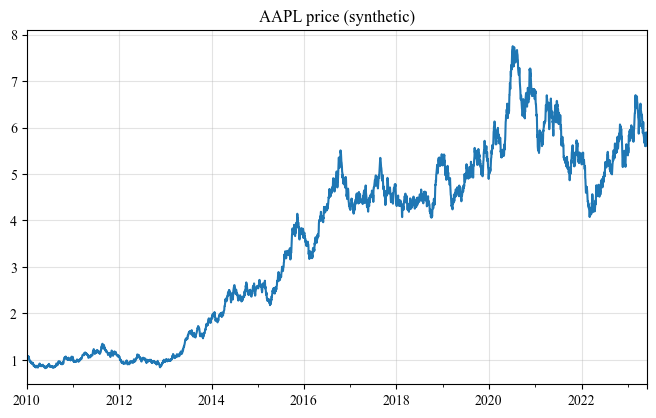

In [4]:
TICKER = "AAPL"
START  = "2010-01-01"   # use a long sample to stabilize H
USE_MARKET = True

try:
    if USE_MARKET:
        import yfinance as yf
        px = yf.download(TICKER, start=START, progress=False)["Adj Close"].dropna()
        src = "market"
    else:
        raise RuntimeError("forced synthetic")
except Exception as e:
    print(f"[INFO] market load failed: {e}; using synthetic GBM fallback")
    rng = np.random.RandomState(42)
    n   = 3500
    dt  = 1/252
    mu, sig = 0.06, 0.25
    lnS = np.cumsum((mu-0.5*sig**2)*dt + sig*np.sqrt(dt)*rng.randn(n))
    px  = pd.Series(np.exp(lnS), index=pd.bdate_range("2010-01-01", periods=n))
    src = "synthetic"

print(f"[INFO] source={src}, n={len(px)}")
px.plot(title=f"{TICKER} price ({src})"); plt.show()


## 2) Build series: returns & volatility proxies

- **returns**: $ r_t = \log S_t - \log S_{t-1} $  
- **vol proxies** (daily):  
  * $|r_t|$  
  * $r_t^2$  
  * $\log(|r_t|+\varepsilon)$ (often used in rough-vol papers)

We’ll estimate H on each.


len returns=3499, |r|=3499, r^2=3499, log|r|=3499


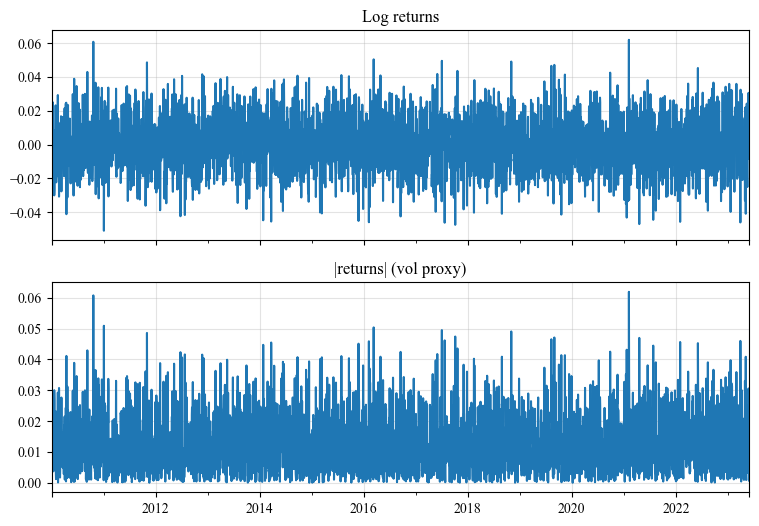

In [5]:
eps   = 1e-8
rets  = np.log(px).diff().dropna()
vol_abs = np.abs(rets).dropna()
vol_sq  = (rets**2).dropna()
vol_log = np.log(np.abs(rets) + eps).dropna()

print(f"len returns={len(rets)}, |r|={len(vol_abs)}, r^2={len(vol_sq)}, log|r|={len(vol_log)}")
fig, ax = plt.subplots(2,1, figsize=(9,6), sharex=True)
rets.plot(ax=ax[0], title="Log returns")
vol_abs.plot(ax=ax[1], title="|returns| (vol proxy)")
plt.show()


## 3) Point estimates of H (R/S and DFA)

R/S is simple but biased on some series; DFA is typically more stable.  
We report both for **returns** and DFA for the **vol proxies**.


In [6]:
H_rs_rets  = hurst_rs(rets.values, min_window=8)
H_dfa_rets = hurst_dfa(rets.values, order=1)

H_dfa_abs  = hurst_dfa(vol_abs.values, order=1)
H_dfa_sq   = hurst_dfa(vol_sq.values,  order=1)
H_dfa_log  = hurst_dfa(vol_log.values, order=1)

print("Hurst (point estimates):")
print(f"  Returns   : R/S={H_rs_rets:.3f}  DFA={H_dfa_rets:.3f}")
print(f"  |r| proxy : DFA={H_dfa_abs:.3f}")
print(f"  r^2 proxy : DFA={H_dfa_sq:.3f}")
print(f"  log|r|    : DFA={H_dfa_log:.3f}")


Hurst (point estimates):
  Returns   : R/S=0.562  DFA=0.492
  |r| proxy : DFA=0.444
  r^2 proxy : DFA=0.445
  log|r|    : DFA=0.451


## 4) Scaling diagnostics (log–log regressions)

To **see** the slope $H$, we reconstruct the points used by the estimators and fit a straight line in log–log:

- **R/S**: $ \log E[R/S]_w $ vs $ \log w $  
- **DFA**: $ \log F(s) $ vs $ \log s $

A near-linear relation over **intermediate** scales indicates a good fit.


H (returns): R/S=0.562  DFA=0.492


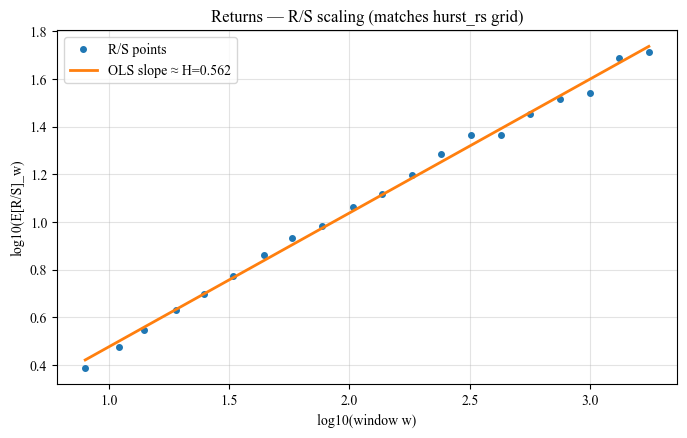

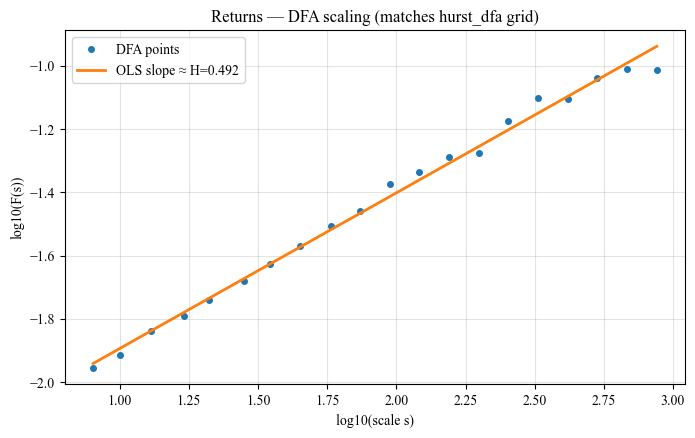

In [7]:
def _logspace_int(low, high, num=20):
    if high < low: 
        return np.array([], dtype=int)
    g = np.logspace(np.log10(low), np.log10(high), num=num)
    g = np.unique(np.clip(np.round(g), low, high).astype(int))
    return g

def rs_scaling_points(series, min_window=8, max_window=None, num=20):
    """Return (log10(w), log10(E[R/S]_w)) using the same window grid as hurst_rs."""
    x = np.asarray(series, float).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    if n < max(2*min_window, 32):
        return None, None

    if max_window is None:
        max_window = n // 2
    max_window = max(max_window, min_window + 1)
    windows = _logspace_int(min_window, max_window, num=num)

    pts = []
    for w in windows:
        nb = n // w
        if nb < 2: 
            continue
        vals = []
        for i in range(nb):
            seg = x[i*w:(i+1)*w]
            seg = seg - seg.mean()
            if seg.size < 2: 
                continue
            Z = np.cumsum(seg)
            R = Z.max() - Z.min()
            S = seg.std(ddof=1)
            if S > 0:
                vals.append(R/S)
        if vals:
            pts.append((w, np.mean(vals)))
    if not pts:
        return None, None
    W, RS = np.array([u for u,_ in pts]), np.array([v for _,v in pts])
    return np.log10(W), np.log10(RS)

def dfa_scaling_points(series, order=1, num=20):
    """Return (log10(s), log10(F(s))) using the same scale grid as hurst_dfa."""
    x = np.asarray(series, float).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    if n < 32:
        return None, None
    y = x - x.mean()
    Y = np.cumsum(y)

    s_min, s_max = 8, max(n//4, 9)
    scales = _logspace_int(s_min, s_max, num=num)
    pts = []
    for s in scales:
        nw = n // s
        if nw < 2: 
            continue
        Yc = Y[:nw*s].reshape(nw, s)
        t = np.arange(s, dtype=float)
        f2 = []
        for j in range(nw):
            z = Yc[j]
            if np.allclose(z, z[0]):
                f2.append(0.0); continue
            co = np.polyfit(t, z, deg=order)
            tr = np.polyval(co, t)
            f2.append(np.mean((z - tr)**2))
        if f2:
            pts.append((s, np.sqrt(np.mean(f2))))
    if not pts:
        return None, None
    S, F = np.array([u for u,_ in pts]), np.array([v for _,v in pts])
    return np.log10(S), np.log10(F)

# --- compute H with your module (authoritative numbers) ---
H_rs = hurst_rs(rets.values, min_window=8)
H_dfa = hurst_dfa(rets.values, order=1)
print(f"H (returns): R/S={H_rs:.3f}  DFA={H_dfa:.3f}")

# --- plot R/S scaling (returns) ---
lw, lr = rs_scaling_points(rets.values, min_window=8, max_window=None, num=20)
if lw is not None:
    slope, intercept = np.polyfit(lw, lr, 1)
    plt.plot(lw, lr, "o", ms=4, label="R/S points")
    plt.plot(lw, slope*lw + intercept, "-", lw=2, label=f"OLS slope ≈ H={slope:.3f}")
    plt.xlabel("log10(window w)")
    plt.ylabel("log10(E[R/S]_w)")
    plt.title("Returns — R/S scaling (matches hurst_rs grid)")
    plt.legend(); plt.show()

# --- plot DFA scaling (returns) ---
ls, lf = dfa_scaling_points(rets.values, order=1, num=20)
if ls is not None:
    slope, intercept = np.polyfit(ls, lf, 1)
    plt.plot(ls, lf, "o", ms=4, label="DFA points")
    plt.plot(ls, slope*ls + intercept, "-", lw=2, label=f"OLS slope ≈ H={slope:.3f}")
    plt.xlabel("log10(scale s)")
    plt.ylabel("log10(F(s))")
    plt.title("Returns — DFA scaling (matches hurst_dfa grid)")
    plt.legend(); plt.show()

## 5) Rolling H (optional)

We estimate **rolling DFA(H)** on returns to see regime changes.  
(Choose a window large enough to stabilize the slope, e.g., 500 trading days.)


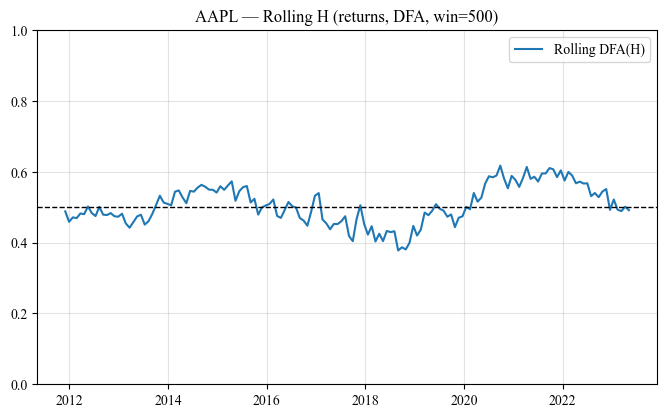

In [8]:
def rolling_hurst_dfa(x, win=500, step=20, order=1):
    x = np.asarray(x, float)
    idx, vals = [], []
    for i in range(win, len(x)+1, step):
        vals.append(hurst_dfa(x[i-win:i], order=order))
        idx.append(i)
    return np.array(idx), np.array(vals)

idx, roll = rolling_hurst_dfa(rets.values, win=500, step=20, order=1)
if len(roll):
    t = rets.index[idx-1]
    plt.plot(t, roll, label="Rolling DFA(H)")
    plt.axhline(0.5, color="k", lw=1, ls="--")
    plt.title(f"{TICKER} — Rolling H (returns, DFA, win=500)")
    plt.ylim(0.0, 1.0)
    plt.legend(); plt.show()


## 6) Summary & interpretation

**Typical outcomes (daily data):**
- **Returns** often give$H \approx 0.5$ → memoryless, close to Brownian.  
- **Vol proxies** can show **persistence** ($H>0.5$), but estimates are **sensitive** to:
  * sample length / regime,
  * scale band used in the regression,
  * proxy choice (|r| vs r² vs log|r|).

**Tips:**
- Prefer DFA over R/S for stability.  
- Use **long samples** and focus on **intermediate scales**.  
- For “rough volatility” research, analyze **log|r|** or **high-frequency realized vol**, where persistence/roughness is clearer.  
